In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_from_disk
import torch
import numpy as np
import os
from datasets import DatasetDict

In [2]:
script_dir = os.path.abspath('')
dataset_folder = os.path.join(script_dir, "../../datasets/PCOP/data")
annotations_folder = os.path.join(script_dir, "../../datasets/PCOP/top20")
output_folder = os.path.join(script_dir, "../../datasets/PCOP")

## Load dataset

In [3]:
# Load the dataset
dataset = load_from_disk(annotations_folder)

In [4]:
dataset

Dataset({
    features: ['text', 'labels'],
    num_rows: 2855
})

In [5]:
dataset[0]['labels']

[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

## HerBert - base - cased

In [8]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

def preprocess_function(examples):
    tokenized_examples = tokenizer(examples["text"], truncation=True, padding=True)
    
    # Extract labels and reshape them
    labels = torch.tensor(examples["labels"], dtype=torch.float32)
    labels = labels.squeeze(1)
    
    # Update the tokenized examples with the adjusted labels
    tokenized_examples["labels"] = labels
    
    return tokenized_examples
    

# Tokenize
tokenized_datasets = dataset.map(preprocess_function, batched=True)
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_test_split = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

In [7]:
# Load the HerBERT model modified for multi-label classification
model = AutoModelForSequenceClassification.from_pretrained("allegro/herbert-base-cased", num_labels=20, problem_type="multi_label_classification")

C:\Users\arkad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Define training arguments
batch_size = 4
metric_name = "f1"

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
)


from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split["train"], 
    eval_dataset=train_test_split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [9]:
# Train the model
trainer.train()

wandb: Currently logged in as: vgs (vosges). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.209200,0.122868,0.676717,0.776260,0.502627
2,0.109400,0.090379,0.773354,0.845593,0.637478
3,0.077400,0.074257,0.824638,0.889386,0.688266
4,0.065600,0.067825,0.826244,0.892012,0.695271
5,0.051700,0.063498,0.840621,0.907544,0.709282
6,0.047400,0.064688,0.838004,0.917992,0.698774
7,0.039700,0.060510,0.849201,0.917637,0.726795
8,0.031400,0.060127,0.852186,0.919758,0.742557
9,0.030000,0.060026,0.856346,0.920086,0.747811
10,0.027900,0.059647,0.852551,0.917273,0.747811


Checkpoint destination directory ./results\checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=5710, training_loss=0.06459724113945368, metrics={'train_runtime': 2141.5806, 'train_samples_per_second': 10.665, 'train_steps_per_second': 2.666, 'total_flos': 6010427721154560.0, 'train_loss': 0.06459724113945368, 'epoch': 10.0})

In [10]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.059646934270858765,
 'eval_f1': 0.8525506638714188,
 'eval_roc_auc': 0.9172726650910126,
 'eval_accuracy': 0.7478108581436077,
 'eval_runtime': 14.4284,
 'eval_samples_per_second': 39.575,
 'eval_steps_per_second': 9.911,
 'epoch': 10.0}

In [11]:
trainer.state.log_history

[{'loss': 0.2092,
  'grad_norm': 0.8179100751876831,
  'learning_rate': 1.8248686514886167e-05,
  'epoch': 0.88,
  'step': 500},
 {'eval_loss': 0.12286806851625443,
  'eval_f1': 0.6767169179229481,
  'eval_roc_auc': 0.7762597054460404,
  'eval_accuracy': 0.5026269702276708,
  'eval_runtime': 14.9559,
  'eval_samples_per_second': 38.179,
  'eval_steps_per_second': 9.561,
  'epoch': 1.0,
  'step': 571},
 {'loss': 0.1094,
  'grad_norm': 0.5455483198165894,
  'learning_rate': 1.649737302977233e-05,
  'epoch': 1.75,
  'step': 1000},
 {'eval_loss': 0.09037870913743973,
  'eval_f1': 0.773353751914242,
  'eval_roc_auc': 0.8455933987515534,
  'eval_accuracy': 0.637478108581436,
  'eval_runtime': 15.4754,
  'eval_samples_per_second': 36.897,
  'eval_steps_per_second': 9.24,
  'epoch': 2.0,
  'step': 1142},
 {'loss': 0.0774,
  'grad_norm': 1.044076919555664,
  'learning_rate': 1.4746059544658496e-05,
  'epoch': 2.63,
  'step': 1500},
 {'eval_loss': 0.07425693422555923,
  'eval_f1': 0.824637681159

In [14]:
train_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
valid_losses = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]
epochs = range(1, len(train_losses) + 1)

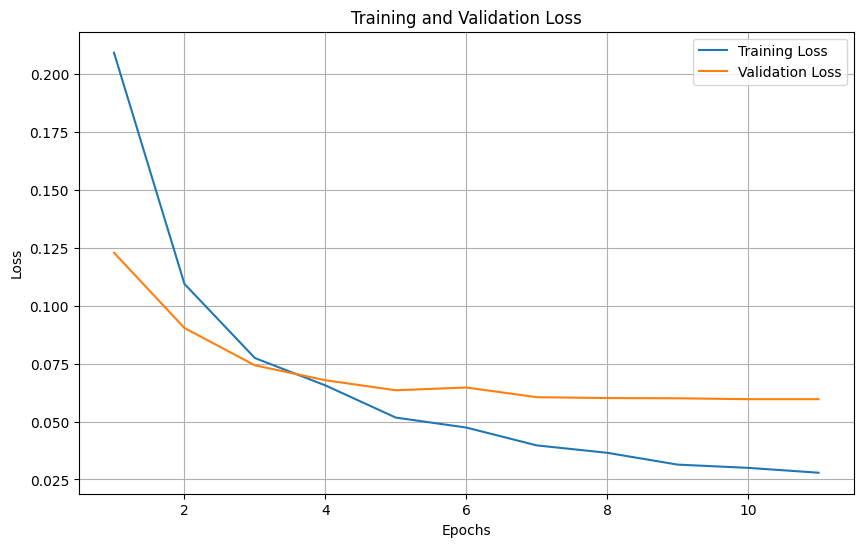

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## RoBerta v2 base

In [6]:
import torch, os
from transformers import RobertaModel, AutoModel, PreTrainedTokenizerFast

In [38]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [19]:
model_dir = os.path.join(script_dir, "../robertav2base")
tokenizer = PreTrainedTokenizerFast(tokenizer_file=os.path.join(model_dir, "tokenizer.json"))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sdadas/polish-roberta-base-v2")

def preprocess_function(examples):
    tokenized_examples = tokenizer(examples["text"], truncation=True, padding=True)
    
    # Extract labels and reshape them
    labels = torch.tensor(examples["labels"], dtype=torch.float32)
    labels = labels.squeeze(1)
    
    # Update the tokenized examples with the adjusted labels
    tokenized_examples["labels"] = labels
    
    return tokenized_examples
    

# Tokenize
tokenized_datasets = dataset.map(preprocess_function, batched=True)
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_test_split = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

Map:   0%|          | 0/2855 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("sdadas/polish-roberta-base-v2", num_labels=20, problem_type="multi_label_classification")

In [39]:
# Define training arguments
batch_size = 4
metric_name = "f1"

training_args = TrainingArguments(
    output_dir="./results-roberta",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
)


from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split["train"], 
    eval_dataset=train_test_split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [33]:
tokenizer.pad_token = tokenizer.eos_token

In [34]:
# Train the model
trainer.train()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
